# Publications, datasets, and software by a particular researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications, datasets and software authored by a particular researcher, using his/her ORCID ID.

In [102]:
# Prepare the R graphql client.

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("stringr")
#install.packages("RColorBrewer")

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")
library("stringr")
library("RColorBrewer")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [103]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications, datasets and software with DataCite DOIs linked to that ORCID account.

orcid <- c("https://orcid.org/0000-0003-1419-2405")
style <- c("apa")
locale <- c("en-US")

query <- str_interp("{
  person(id: \"${orcid}\") {
    id
    type
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
        formattedCitation(style: \"${style}\", locale: \"${locale}\")
      }
      edges {
        sourceId
        targetId
      }
    }
    datasets(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
        formattedCitation(style: \"${style}\", locale: \"${locale}\")
      }
      edges {
        sourceId
        targetId
      }
    }
    softwareSourceCodes(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
        formattedCitation(style: \"${style}\", locale: \"${locale}\")
      }
      edges {
        sourceId
        targetId
      }
    }
  }
}")

In [104]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [105]:
# Get the name of the researcher with the ORCID ID we used

display_markdown(data$data$person$name)

Martin Fenner

In [106]:
# Get the number of publications

display_json(data$data$person$publications$totalCount)
display_json(data$data$person$datasets$totalCount)
display_json(data$data$person$softwareSourceCodes$totalCount)

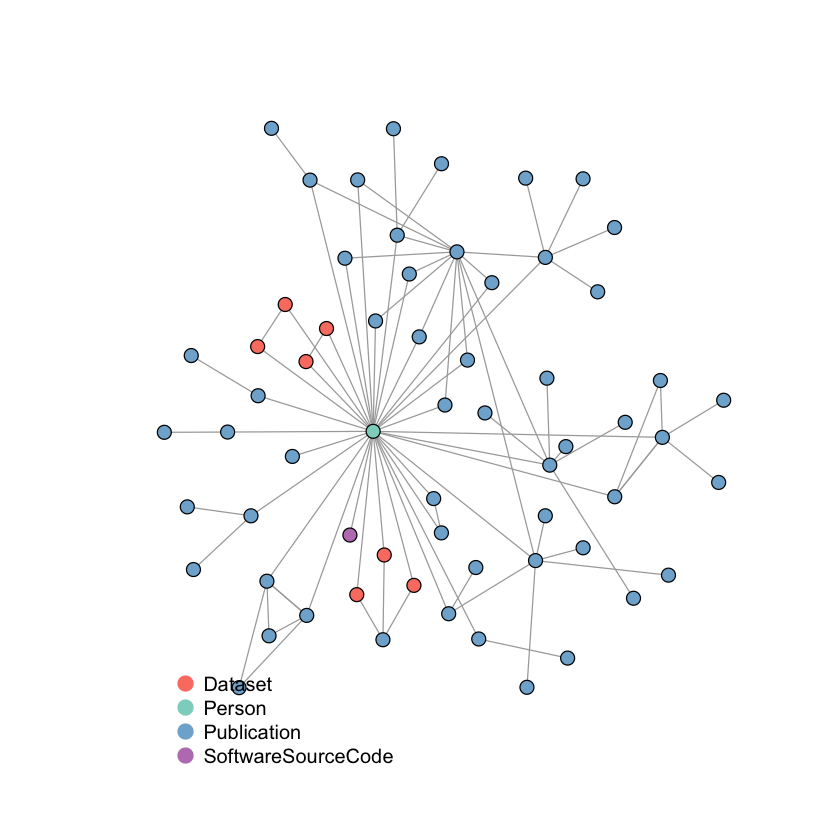

In [107]:
# generate data frame for nodes
people <- data.frame(id=data$data$person$id, pid_type=data$data$person$type)
publications <- data.frame(id=data$data$person$publications$nodes$id, pid_type=c('Publication'))
datasets <- data.frame(id=data$data$person$datasets$nodes$id, pid_type=data$data$person$datasets$nodes$type)
softwareSourceCodes <- data.frame(id=data$data$person$softwareSourceCodes$nodes$id, pid_type=data$data$person$softwareSourceCodes$nodes$type)
publication_references <- data.frame(id=bind_rows(data$data$person$publications$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
dataset_references <- data.frame(id=bind_rows(data$data$person$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
#software_references <- data.frame(id=bind_rows(data$data$person$softwareSourceCodes$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
nodes <- unique(rbind(people, publications, datasets, softwareSourceCodes, publication_references, dataset_references))

publication_edges <- data.frame(to=publications[,1], from=data$data$person$id)
dataset_edges <- data.frame(to=datasets[,1], from=data$data$person$id)
software_edges <- data.frame(to=softwareSourceCodes[,1], from=data$data$person$id)
edges <- unique(rbind(publication_edges, dataset_edges, software_edges))
    
# loop through nodes, as they can have more than one edge
publications_with_references <- bind_rows(data$data$person$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
datasets_with_references <- bind_rows(data$data$person$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
softwareSourceCodes_with_references <- bind_rows(data$data$person$softwareSourceCodes$nodes) %>% filter(lengths(relatedIdentifiers) != 0)

for (i in 1:nrow(publications_with_references)) {
  row <- data.frame(to=unlist(publications_with_references[i,3]), from=publications_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

for (i in 1:nrow(datasets_with_references)) {
  row <- data.frame(to=unlist(datasets_with_references[i,3]), from=datasets_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

#for (i in 1:nrow(softwareSourceCodes_with_references)) {
#  row <- data.frame(to=unlist(softwareSourceCodes_with_references[i,3]), from=softwareSourceCodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

# express DOIs as URLs
nodes <- nodes %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))

# add node colors
cols <- brewer.pal(12, "Set3")
V(g)[(V(g)$pid_type=="Publication")]$color<-cols[5]
V(g)[(V(g)$pid_type=="Person")]$color<-cols[1]
V(g)[(V(g)$pid_type=="Dataset")]$color<-cols[4]
V(g)[(V(g)$pid_type=="SoftwareSourceCode")]$color<-cols[10]

# add labels to selected nodes
V(g)$label=NA

V(g)$size <- 5
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, layout=l, arrow.mode=0)

# Add a legend
# pid_type is sorted alphabetically: 'Dataset' 'Person' 'Publication' 'SoftwareSourceCode'
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = cols[c(4,1,5,10)], bty = "n", pch=20 , pt.cex = 2.5, cex = 1, horiz = FALSE, inset = c(0.1, -0.1))

In [108]:
# Generate a list of formatted references in APA format for the publications, datasets and software

formattedPublicationReferences <- data.frame(reference=data$data$person$publications$nodes$formattedCitation)
display_markdown('## Publications')
for (i in 1:nrow(formattedPublicationReferences)) {
  display_html(paste(formattedPublicationReferences[i,1], '<p/>'))
}

formattedDatasetReferences <- data.frame(reference=data$data$person$datasets$nodes$formattedCitation)
display_markdown('## Datasets')
for (i in 1:nrow(formattedDatasetReferences)) {
  display_html(paste(formattedDatasetReferences[i,1], '<p/>'))
}

formattedSoftwareSourceCodeReferences <- data.frame(reference=data$data$person$softwareSourceCodes$nodes$formattedCitation)
display_markdown('## Software')
for (i in 1:nrow(formattedSoftwareSourceCodeReferences)) {
  display_html(paste(formattedSoftwareSourceCodeReferences[i,1], '<p/>'))
}

## Publications

Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. https://doi.org/10.5281/ZENODO.1120261

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. https://doi.org/10.5281/ZENODO.1324295

Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. https://doi.org/10.5281/ZENODO.1324300

Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. https://doi.org/10.5281/ZENODO.1250025

Rous, B., Altman, M., Brand, A., Bilder, G., Ewenstein, J., Fenner, M., … Warner, S. (2018). Committee: ORCID Privacy Committee. https://doi.org/10.23640/07243.5984974.V1

Fenner, M. (2019). RDA Open Science Graphs for FAIR Data Interest Group. https://doi.org/10.5281/ZENODO.3361404

Fenner, M. (2016, April 19). We were out in Force. https://doi.org/10.5438/C3BY-VYZS

Fenner, M. (2015). Overcoming Development Pain (Version 1.0). https://doi.org/10.5438/8QKH-1R6~

Fenner, M. (2016, January 11). Launching the DataCite Status Page. https://doi.org/10.5438/YHCJ-P5HR

Fenner, M., & Garza, K. (2016). Announcing Our New Application Developer. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2019, July 26). Upcoming Changes to DOI Content Negotiation. https://doi.org/10.5438/NZ0M-RB06

Fenner, M. (2016, May 20). Publishing tabular data as blog post. https://doi.org/10.5438/1Z7J-H7VW

ODIN Consortium, Thorisson, G., & Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. https://doi.org/10.6084/M9.FIGSHARE.154691

Lowenberg, D., Fenner, M., & Chodacki, J. (2019). 5 Steps Towards a Dream State: Persistent & Open Data Metrics. https://doi.org/10.5281/ZENODO.2547485

ODIN Consortium, Thorisson, G., & Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. https://doi.org/10.6084/M9.FIGSHARE.154691.V1

Burton, A., Fenner, M., Haak, W., Koers, H., & Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. https://doi.org/10.5281/ZENODO.1120248

Fenner, M. (2019). RDA Open Science Graphs for FAIR Data Interest Group. https://doi.org/10.5281/ZENODO.3361405

Fenner, M. (2018, September 18). COUNTER Code of Practice for Research Data Usage Metrics release 1. https://doi.org/10.5438/NB24-T773

Fenner, M. (2015). Discussing the Scholarly Container. https://doi.org/10.5438/D9EQ-9DGA

Fenner, M. (2016, May 4). Thinking about CSV. https://doi.org/10.5438/4QX3-RP8Y

Fenner, M. (2015, September 16). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2015, November 9). Announcing the DataCite Profiles Service. https://doi.org/10.5438/15X1-BJ6R

Wimalaratne, S., & Fenner, M. (2019, June 24). Please welcome Sarala, our new Head of Infrastructure Services. https://doi.org/10.5438/AJ7F-H903

Fenner, M., & Aryani, A. (2019, March 28). Introducing the PID Graph. https://doi.org/10.5438/JWVF-8A66

Laurel, H., Bilder, G., Brown, C., Cruse, P., Devenport, T., Fenner, M., … Smith, A. (2017). ORG ID WG Product Principles and Recommendations. https://doi.org/10.23640/07243.5402047

## Datasets

ODIN Consortium, Fenner, M., & Thorisson, G. (2013). TEST Kickoff report [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V1

Fenner, M., & Adie, E. (2012). CrowdoMeter Tweets [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

Fenner, M., & Adie, E. (2012). CrowdoMeter Tweets [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828.V1

ODIN Consortium, Fenner, M., & Thorisson, G. (2013). D2.2 Kickoff report [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V2

ODIN Consortium, Fenner, M., & Thorisson, G. (2013). TEST do not use!! [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V3

Fenner, M., & Adie, E. (2012). CrowdoMeter Tweet Classifications [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

Fenner, M., & Adie, E. (2012). CrowdoMeter Tweet Classifications [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829.V1

## Software

Fenner, M. (2017, April 28). Content-Negotation: an API for DOI content negotiation. DataCite. https://doi.org/10.5438/T1JG-HVHN